# Importing Libraries & Data📚

In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
directory = r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\annotations"
image_directory = r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images"
df = pd.read_csv(r"C:\Users\ronyj\Downloads\The Guilty\train.csv")
df_test = pd.read_csv(r"C:\Users\ronyj\Downloads\The Guilty\submission.csv")
caffeModel = r"C:\Users\ronyj\Downloads\The Guilty\res10_300x300_ssd_iter_140000.caffemodel"
prototextPath = r"C:\Users\ronyj\Downloads\The Guilty\deploy.prototxt.txt"

# Insights on Dataset 📊

In [3]:
unq_values = df["name"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  15412
Unique Images:  4326

> Null Values in each column <
name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64


In [4]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [5]:
classes = df["classname"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  20

> Classes <
 ['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


<AxesSubplot:title={'center':'Class Distribution'}, xlabel='classname', ylabel='count'>

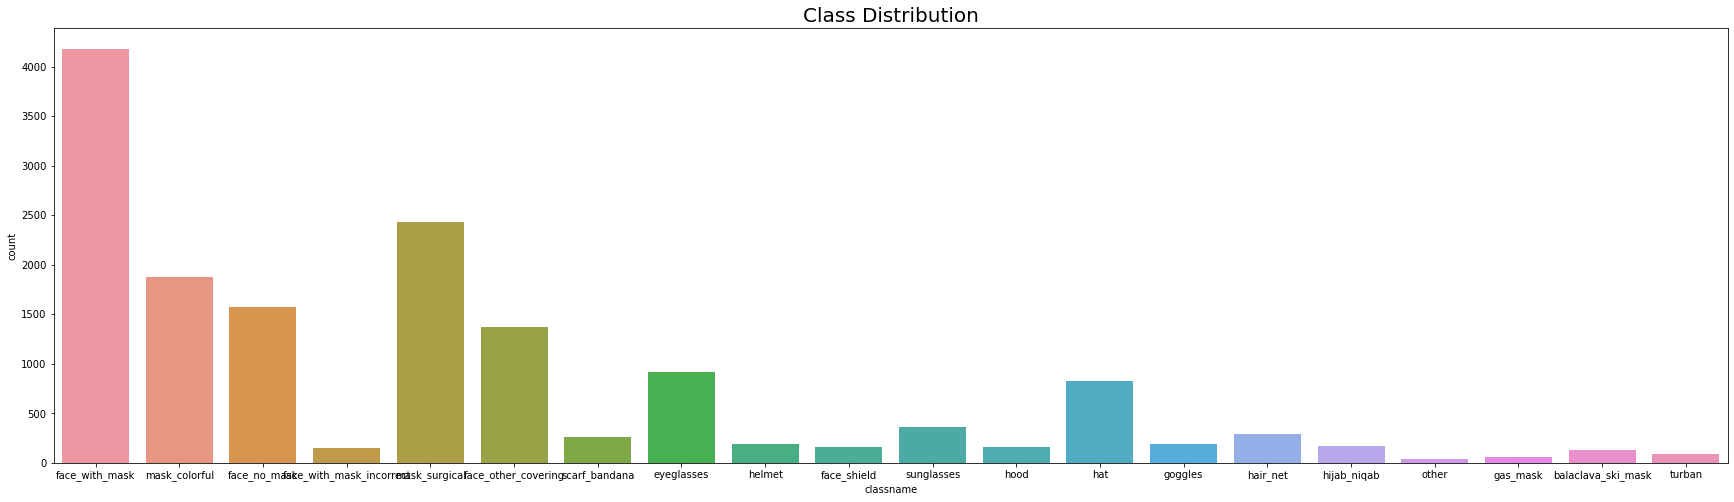

In [6]:
plt.figure(figsize=(30,8))
plt.title('Class Distribution', fontsize= 20)
sns.countplot(x = "classname", data = df)

In [7]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


# Helper Fucntions 🧰

In [8]:
cvNet = cv2.dnn.readNetFromCaffe(prototextPath,caffeModel)

def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Data Processing 📝

In [9]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [10]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

In [11]:
len(data)

5749

C:\Users\ronyj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

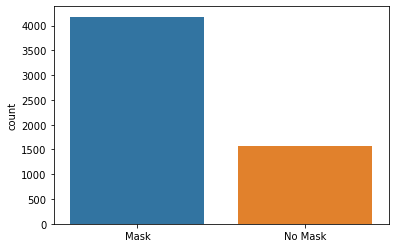

In [12]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [13]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X[0].shape

(124, 124, 3)

In [14]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [15]:
np.unique(Y)
Y.shape

(5749,)

# Training Model 👨‍💻

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 460800)            0

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=2,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/2
143/143 [==============================] - 572s 4s/step - loss: 0.4388 - accuracy: 0.8231 - val_loss: 0.2937 - val_accuracy: 0.8748
Epoch 2/2
143/143 [==============================] - 573s 4s/step - loss: 0.3038 - accuracy: 0.8737 - val_loss: 0.2515 - val_accuracy: 0.8965


# Testing the model 👨‍🔬

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


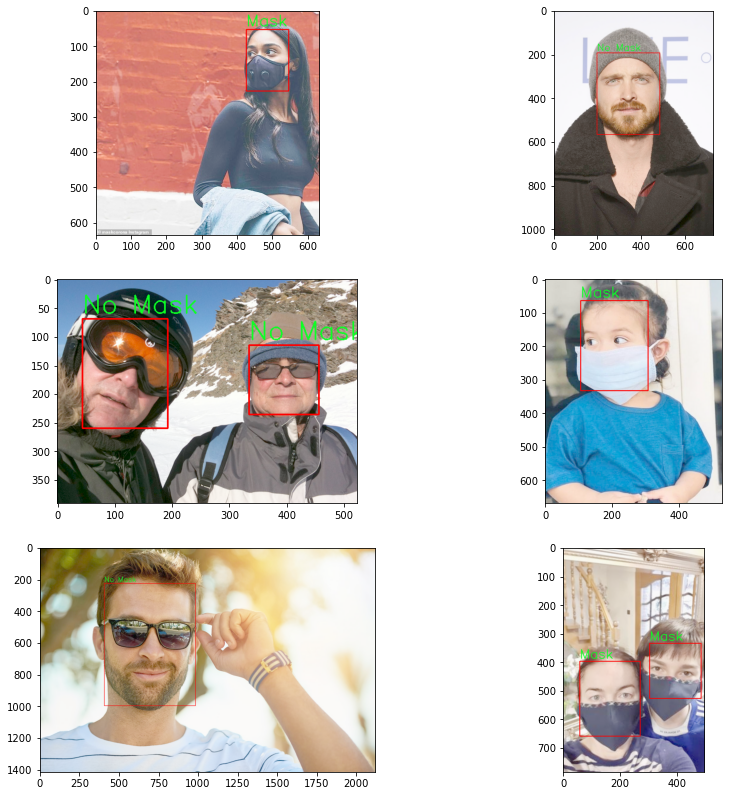

In [26]:
test_images = [r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\1114.png",r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\1165.jpg",r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\2305.png",r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\4229.png",r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\5058.jpg",r"C:\Users\ronyj\Downloads\The Guilty\Medical mask\Medical mask\Medical Mask\images\3832.png"]

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    print(type(blob))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()